In [ ]:
!mkdir output

## Import Dependencies

In [2]:
import cv2
import scipy
import numpy as np
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

## Utils for Homogenous Coordinate

In [34]:
def convert_to_homo(x : np) -> np:
    """
    Convert inhomogeneous coordinate to homogeneous coordinate

    Parameters:\n
    x : inhomogenueous coordinate

    Returns:\n
    t : homogenueous coordinate
    """
    # Shape of x: (3, 2)
    shape = x.shape
    t = np.ones((*shape[:-1], shape[-1] + 1))
    t[..., :-1] = x
    return t

## Implement DLT

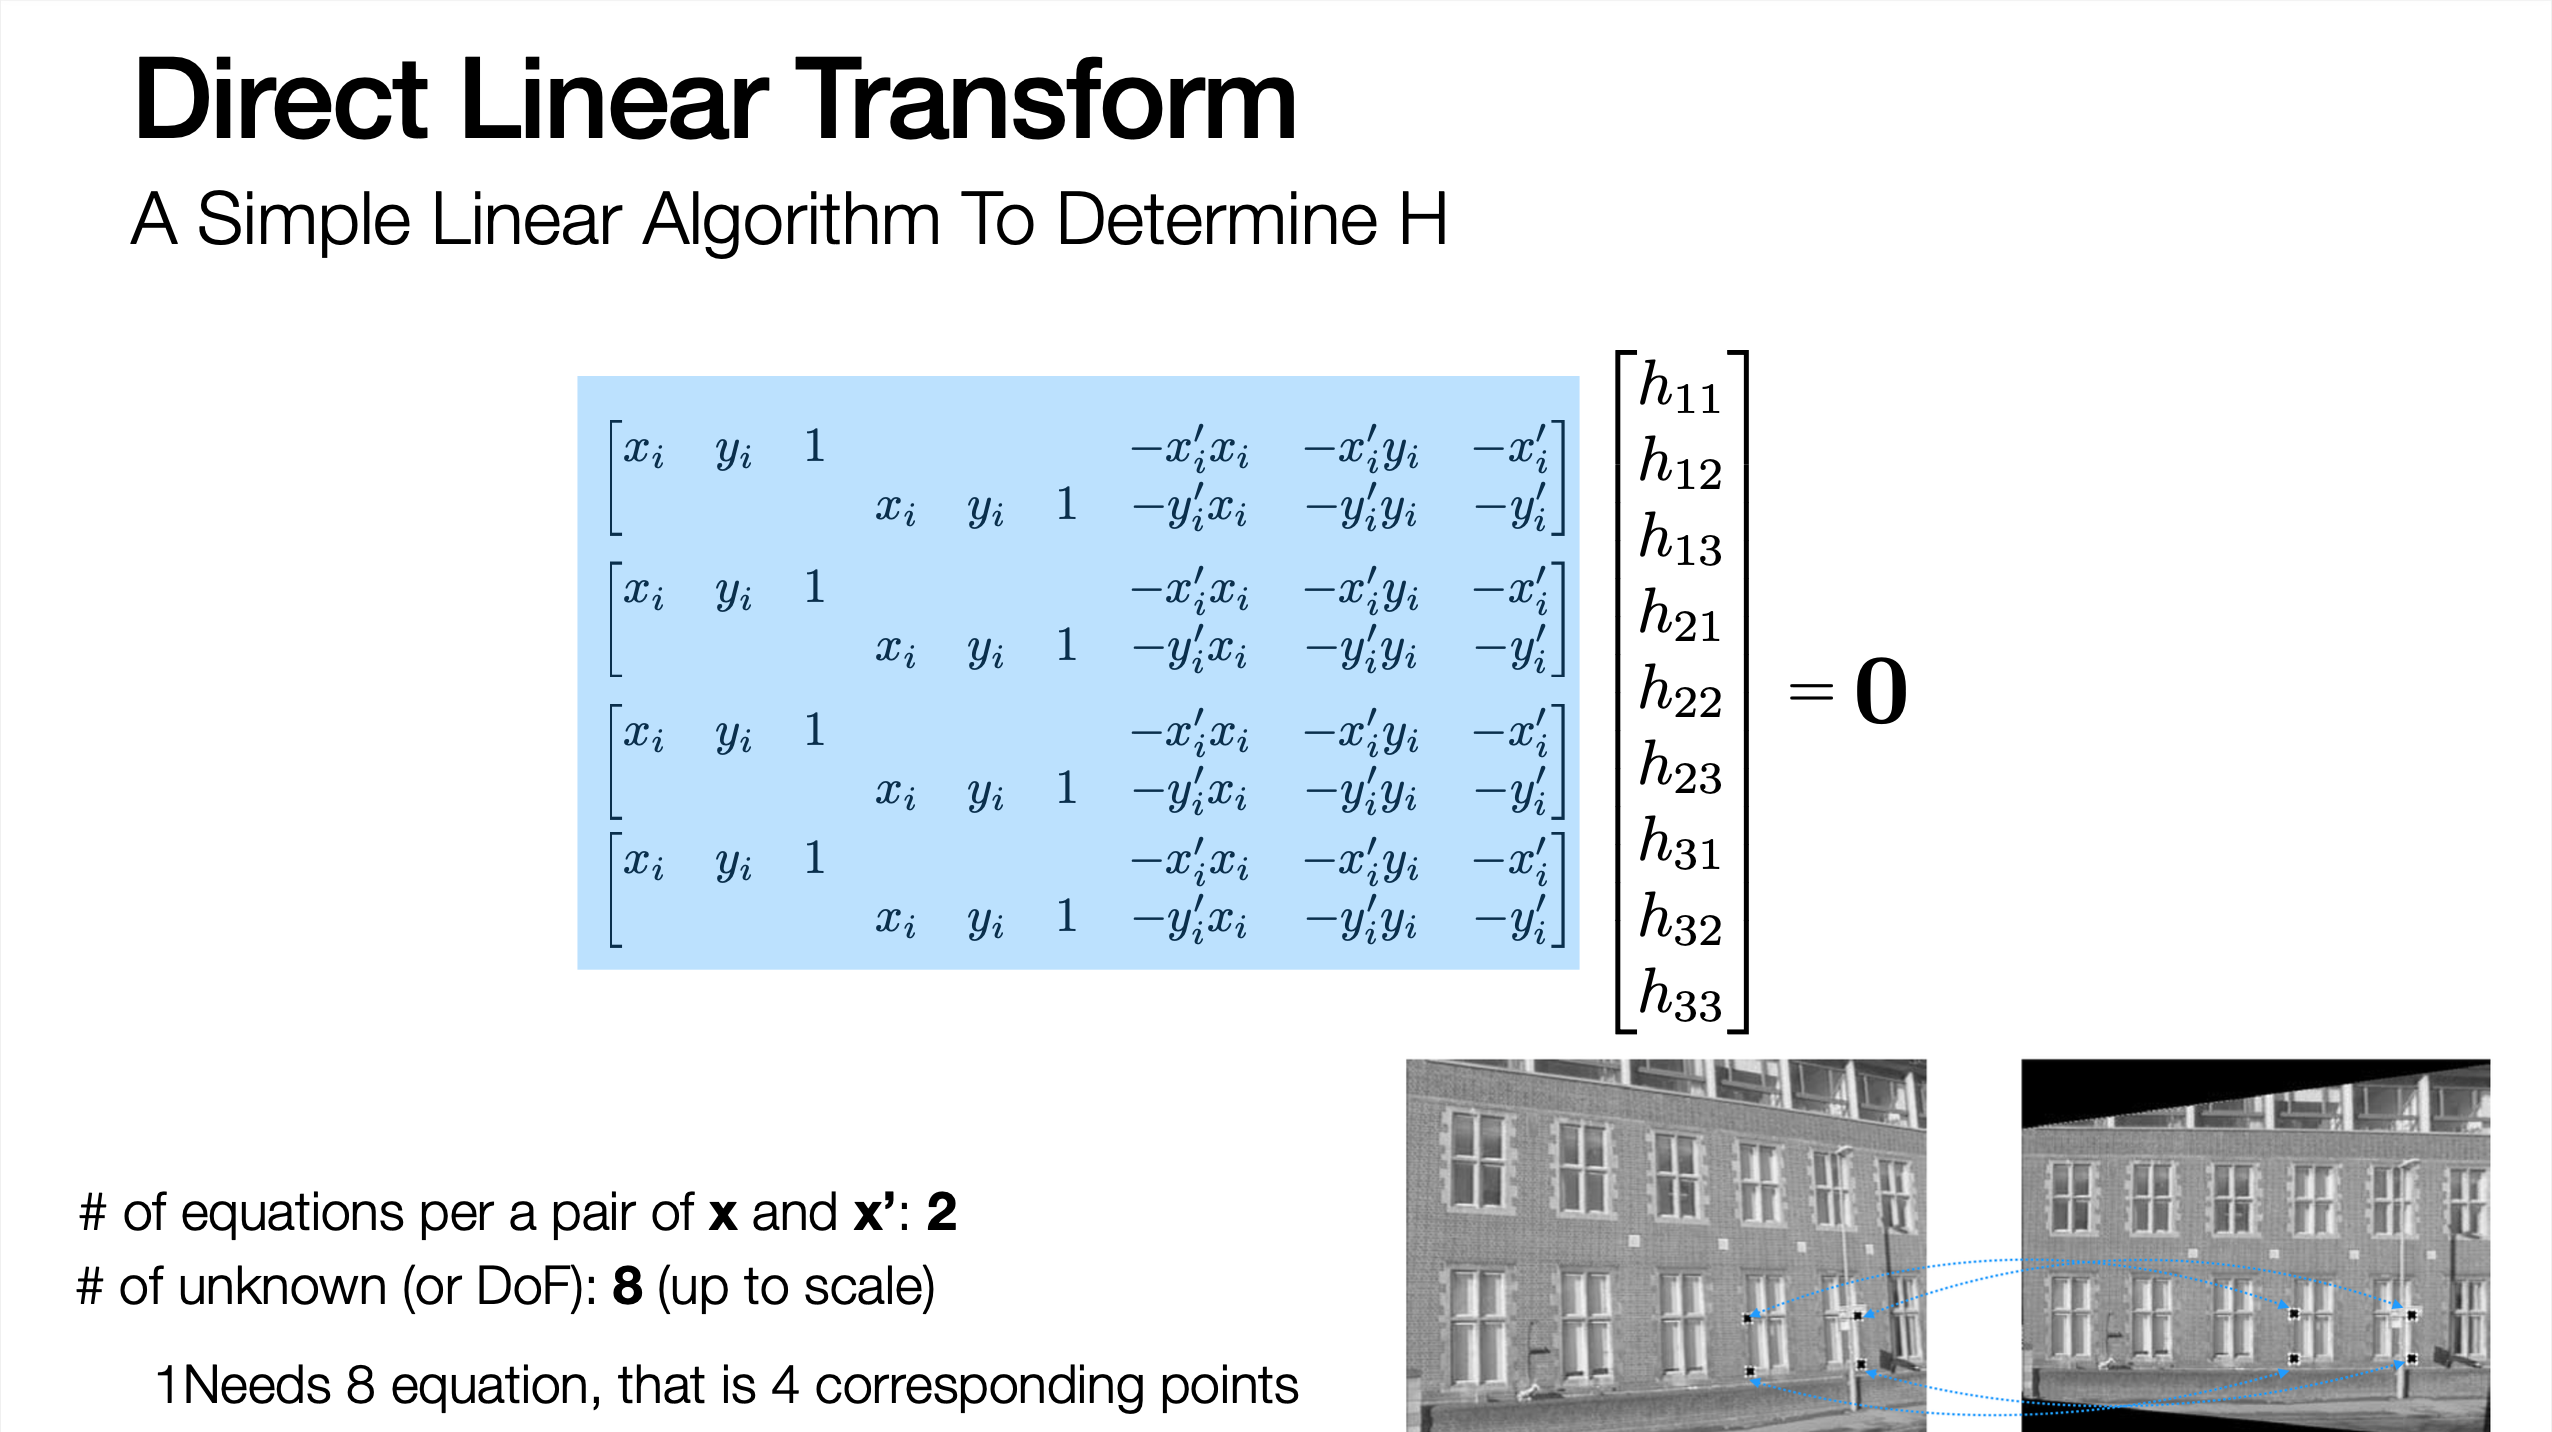

Find h for minimizing \|Ah\| while $\|h \| =1$.

$$
\begin{align*}
\|Ah\| &= (Ah)^T(Ah) \\
&= h^TA^TAh& \\
&= h^T(VD^TU^T)(UDV^T)h  \\
&= h^TVD^TDV^Th \\
& = (V^Th)^T(D^2)(V^Th) \\
& = \sigma_1^2x_1^2 + \dots \sigma_n^2x_n^2 \quad {\rm where}\ x=V^Th \to \| x\|^2 = 1 \\
& \ge \sigma_i^2x_{\arg\min_i \sigma_i}^2
\end{align*}
$$

Thus, h is an eigenvector corresponding to the minimum eigenvalue.


In [35]:
def compute_H(x1, x2):
    """
    Using DLT to compute homography from correspondences
    """
    # Shape of x1: (n, 2)
    # Shape of x2: (n, 2)

    A = np.zeros((len(x1) * 2, 9))
    for i, (_x1, _x2) in enumerate(zip(x1, x2)):
        A[i * 2, :3] = [_x1[0], _x1[1], 1]                        #row(2n) [xi, yi, 1, _, _, _, _, _, _]
        A[i * 2, -3:] = [-_x2[0]*_x1[0], -_x2[0]*_x1[1], -_x2[0]] #row(2n) [xi, yi, 1, _, _, _, -xi'*xi, -xi'*yi, -xi']
        A[i * 2 + 1, 3:6] = [_x1[0], _x1[1], 1]                         #row(2n+1) [_, _, _, xi, yi, 1, _, _, _]
        A[i * 2 + 1, -3:] = [-_x2[1]*_x1[0], -_x2[1]*_x1[1], -_x2[1]]   #row(2n+1) [_, _, _, xi, yi, 1, -xi'*xi, -xi'*yi, -xi']

    u, s, vh = np.linalg.svd(A)
    H = vh[-1].reshape(3, 3)
    return H

## RANSAC Process

In [36]:
def ransac(x1, x2, ransac_n_iter, ransac_thr):
    """
    Execute RANSAC(Random Sample Consensus) to find the homography which has largest correspondences (inliers)
    """
    # Shape of x1: (n, 2)
    # Shape of x2: (n, 2)
    # ransac_n_iter: number of the ransac iteration
    # ransac_thr: threshold for deciding whether the correspondence is inlier or not

    def count_inlier(H, x1, x2, ransac_thr):
        """
        Find the number of correspondences (inliers) which satisfies the given homogrpahy H
        """
        # Shape of H: (3, 3)
        # Shape of x1: (n, 2)
        # Shape of x2: (n, 2)

        x1 = convert_to_homo(x1)
        pred_x2 = (H @ x1.T).T
        pred_x2 = pred_x2[:, :-1] / pred_x2[:, -1:]

        diff = np.linalg.norm(pred_x2 - x2, axis=-1)
        ids = np.nonzero(diff < ransac_thr)[0]

        return len(ids), ids

    best_H = None
    best_inids = None
    best_count = 0
    for _ in range(ransac_n_iter):
        i = np.random.choice(len(x1), size=(4), replace=False)
        p1, p2 = x1[i], x2[i]
        H = compute_H(p1, p2)
        count, ids = count_inlier(H, x1, x2, ransac_thr)

        if count > best_count:
            best_H = H
            best_count = count
            best_inids = ids

    p1, p2 = x1[best_inids], x2[best_inids]
    H = compute_H(p1, p2)

    return H, best_inids

# SIFT Matching

In [51]:
def MatchSIFT(loc1, des1, loc2, des2):
    """
    Estimate Correspondences among two Images using Descriptors
    """
    # Shape of loc1: (n, 2), location of corresponding pixel in image 1
    # Shape of loc2: (n, 2), location of corresponding pixel in image 2
    # Shape of des1: (N, 128), descriptor of the loc1
    # Shape of des2: (N, 128), descriptor of the loc2

    def nn(spt, qry):
        neigh = NearestNeighbors()
        neigh.fit(spt)
        dist, ind = neigh.kneighbors(qry, 2, return_distance=True)

        # select unique descriptor
        return [(i, ind[i][0]) for i, (d1, d2) in enumerate(dist) if d1 < d2 * 0.7]
    
    ind_1to2 = nn(des2, des1)
    ind_2to1 = nn(des1, des2)

    # bi-directional consistency
    ind = set(ind_1to2) & set([(b, a) for a, b in ind_2to1])
    ind = np.array(list(ind))

    x1 = loc1[ind[:, 0]]
    x2 = loc2[ind[:, 1]]

    return x1, x2

## Utils for Pure Rotation

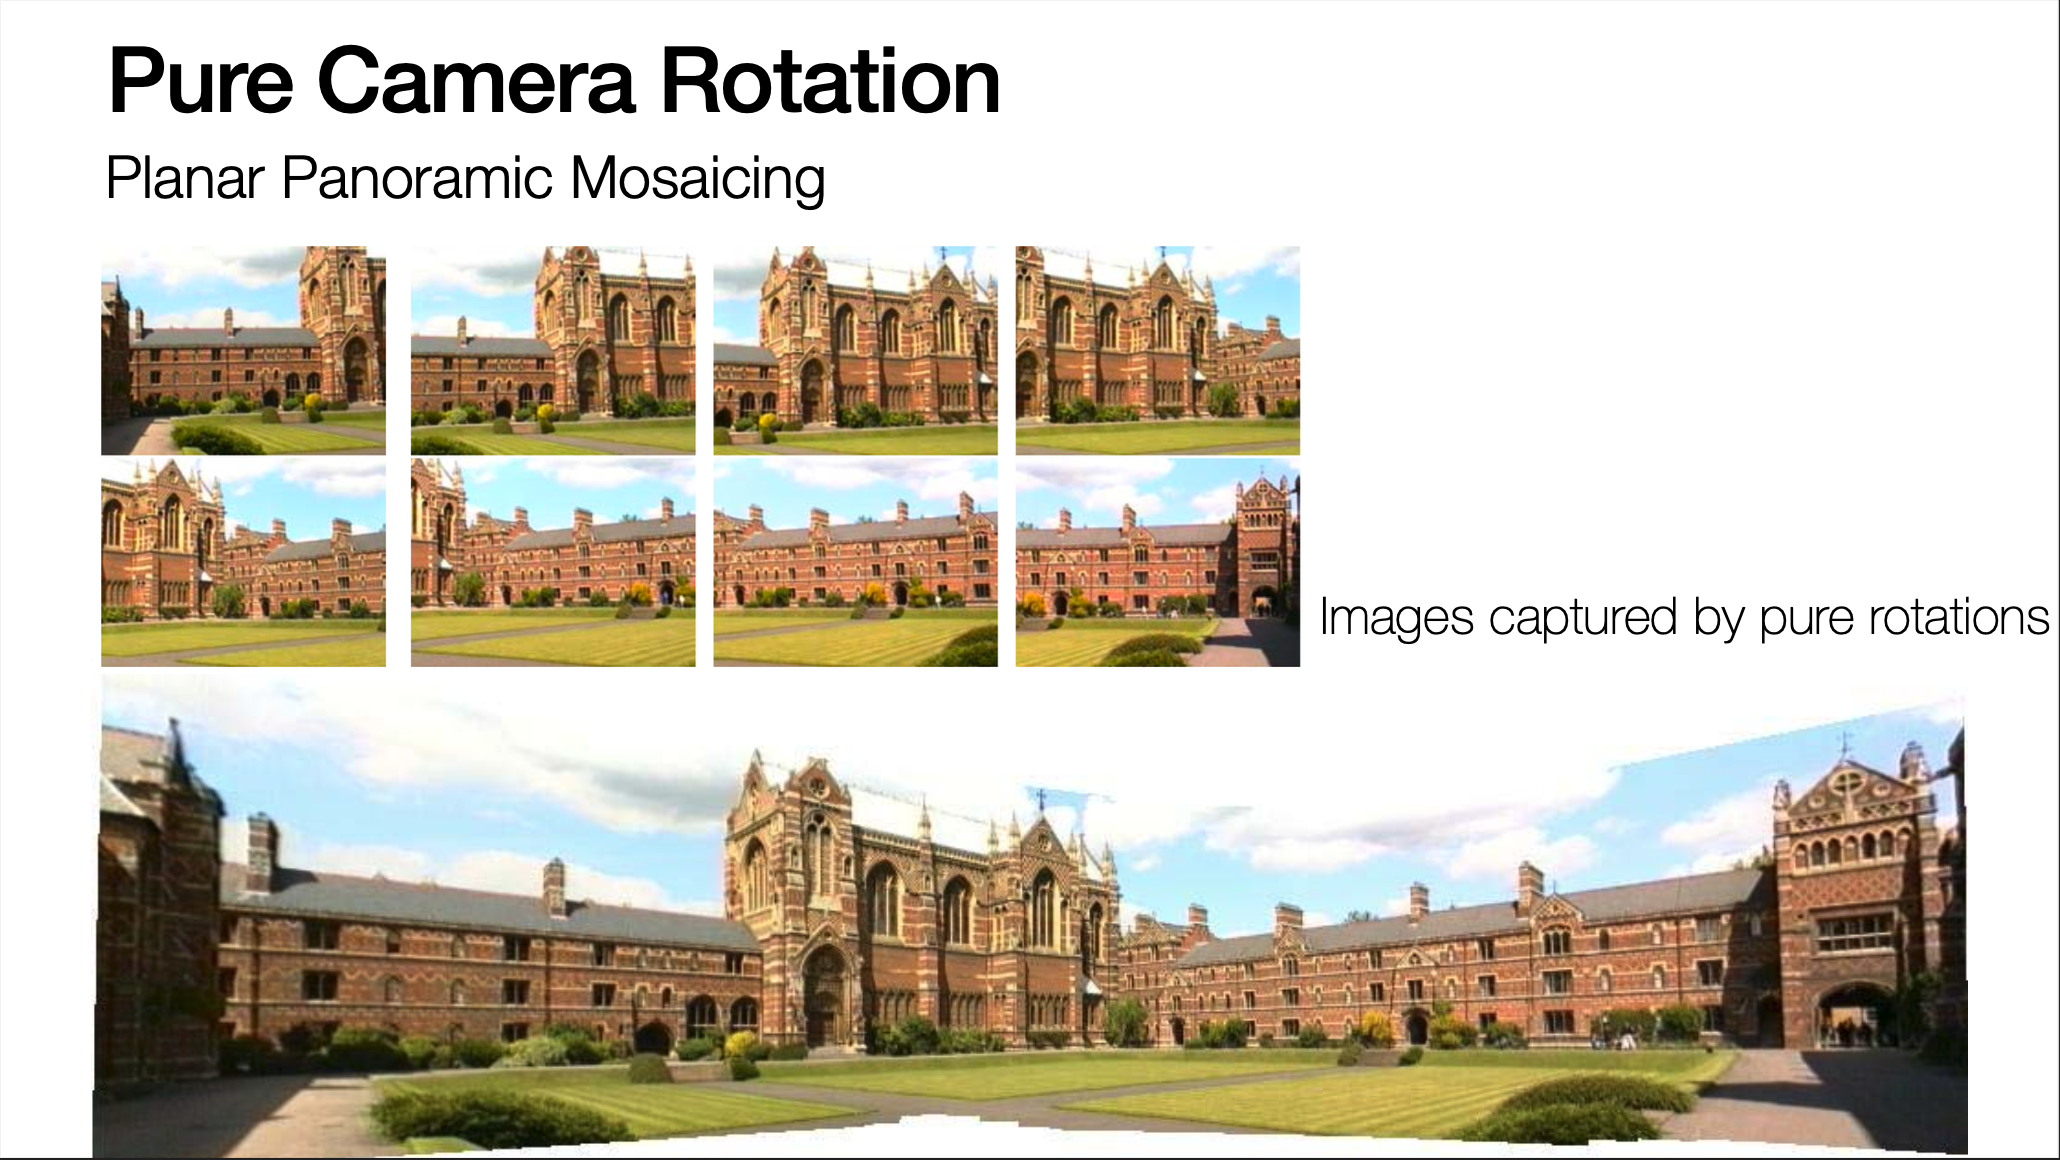

### Pure Rotation
Assume the pure rotation setting and the homography $H$ between the images:

$$x_1 = K\begin{bmatrix}
I&|&0
\end{bmatrix}X$$
$$x_2 = K\begin{bmatrix}
R&|&0
\end{bmatrix}X$$

$$x_2 = H x_1$$

Then, following equation holds:

$$
\begin{align*}
x_2 &= K\begin{bmatrix}
R&|&0
\end{bmatrix}X \\
&= KRK^{-1}(K\begin{bmatrix}
I&|&0
\end{bmatrix}X) \\
&= KRK^{-1}x_1
\end{align*}
$$

Thus, the homography and the rotation can be written as:

$$H = KRK^{-1}$$
$$R = K^{-1}HK$$

In [38]:
def homography2rotation(H, K):
    """
    Convert homography into rotation matrix in case of pure rotation
    """
    # make the determinant of R as 1
    detH = np.linalg.det(H)
    s = np.sign(detH) * np.abs(detH)**(1/3)
    H = H / s

    R = np.linalg.inv(K) @ H @ K
    return R

## Utils for Visualization

In [39]:
def cyclindrical_coordinate(Wc, Hc, K):
    """
    Define cyclindrical coordinate to formulate panorama setting
    """
    h, phi = np.meshgrid(np.arange(Hc), np.linspace(0, 2 * np.pi, Wc), indexing='ij')

    f = K[0, 0]
    x = f * np.sin(phi)
    z = f * np.cos(phi)
    y = h - K[1, 2]

    p = np.stack([x, y, z], axis=-1)
    return p


def project(Hc, Wc, p, K, R, W, H):
    """
    Project cyclindrical coordinate points p into camera rotation R
    """
    cam_p = (R @ p.reshape(-1, 3).T).T
    u = (K @ cam_p.T).T
    u = u[:, :-1] / u[:, -1:]

    mask = np.ones((Hc * Wc), dtype=np.bool8)
    # beyond image size
    mask[u[:, 0] < 0] = False
    mask[u[:, 1] < 0] = False
    mask[u[:, 0] > W - 1] = False
    mask[u[:, 1] > H - 1] = False

    # 3d points behind the camera
    mask[cam_p[:, -1] <= 0] = False

    u = u.reshape(Hc, Wc, -1)
    mask = mask.reshape(Hc, Wc)

    return u, mask


def warp(image_i, u, mask_i):
    """
    Get pixel values from original image (image_id) to the projected panorama pixels (u)
    """
    H = np.arange(image_i.shape[0])
    W = np.arange(image_i.shape[1])
    hids, wids = np.meshgrid(H, W, indexing='ij')
    ids = np.stack([wids, hids], axis=-1).reshape(-1, 2) # since x corresondences to width

    interp = scipy.interpolate.LinearNDInterpolator(ids, image_i.reshape(-1, 3))

    canvas_i = np.zeros((*mask_i.shape, 3), dtype=image_i.dtype)
    canvas_i[mask_i] = interp(u[mask_i])
    return canvas_i


def update_canvas(canvas, canvas_i, mask_i):
    """
    Stitch image into canvas
    """
    rst = canvas.copy()
    rst[mask_i] = canvas_i[mask_i]
    return rst

## Panorama Generation

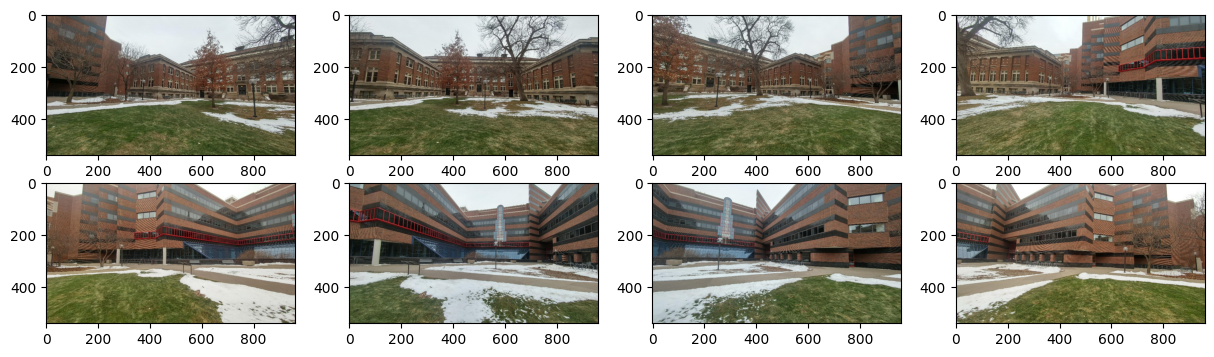

In [40]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15, 4))

for i in range(1, 9):
    image_file = f'./input/{i}.jpg'
    image = mpimg.imread(image_file)

    plt.subplot(2, 4, i)
    plt.imshow(image)

Complete stitching image 1!
Complete stitching image 2!
Complete stitching image 3!
Complete stitching image 4!
Complete stitching image 5!
Complete stitching image 6!
Complete stitching image 7!
Complete stitching image 8!


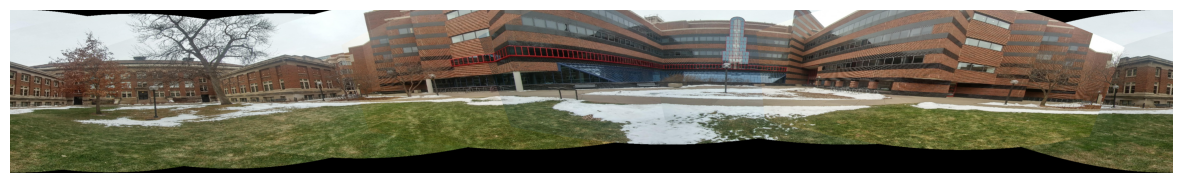

In [53]:
import cv2
import numpy as np

if __name__ == '__main__':
    ransac_n_iter = 500
    ransac_thr = 3
    K = np.asarray([
        [320, 0, 480],
        [0, 320, 270],
        [0, 0, 1]
    ])

    # Read all images
    image_list = []
    for i in range(1, 9):
        image_file = f'./input/{i}.jpg'
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(image)

    rot_list = []
    rot_list.append(np.eye(3))
    for i in range(len(image_list) - 1):
        # Load consecutive images I_i and I_{i+1}
        i1 = image_list[i]
        i2 = image_list[i+1]

        # Create SIFT object
        sift = cv2.SIFT_create()

        # Convert images to greyscaleSS
        i1_grey = cv2.cvtColor(i1,cv2.COLOR_BGR2GRAY)
        i2_grey = cv2.cvtColor(i2,cv2.COLOR_BGR2GRAY)

        # Detect Keypoints and Descriptors using SIFTSS
        key1, des1 = sift.detectAndCompute(i1, None)
        key2, des2 = sift.detectAndCompute(i2, None)
        # Key point locations in I_i and I_i+1
        loc1 = np.array([key1[n].pt for n in range(0, len(key1))])
        loc2 = np.array([key2[n].pt for n in range(0, len(key2))])
        # Find the matches between two images (x1 <--> x2)
        x1, x2 = MatchSIFT(loc1, des1, loc2, des2)

        # Estimate the homography between images using RANSAC
        H, inlier = ransac(x1, x2, ransac_n_iter, ransac_thr)

        # Compute the relative rotation matrix R
        R = homography2rotation(H, K)

		    # Compute R_new (or R_i+1)
        R_new = R @ rot_list[-1]
        rot_list.append(R_new)

    Him = image_list[0].shape[0]
    Wim = image_list[0].shape[1]

    Hc = Him
    Wc = len(image_list) * Wim // 2

    canvas = np.zeros((Hc, Wc, 3), dtype=np.uint8)
    p = cyclindrical_coordinate(Wc, Hc, K)

    fig = plt.figure('panorama', figsize=(15, 4))
    plt.axis('off')
    plt.ion()

    for i, (im_i, rot_i) in enumerate(zip(image_list, rot_list)):
        # Project the 3D points to the i-th camera plane
        u, mask_i = project(Hc, Wc, p, K, rot_i, Wim, Him)
        # Warp the image to the cylindrical canvas
        canvas_i = warp(im_i, u, mask_i)
        # Update the canvas with the new warped image
        canvas = update_canvas(canvas, canvas_i, mask_i)
        plt.imshow(canvas)
        plt.savefig('./output/{}.png'.format(i+1), dpi=600, bbox_inches = 'tight', pad_inches = 0)
        print(f"Complete stitching image {i+1}!")